<a href="https://colab.research.google.com/github/Devdeep-J-S/Vision-Transformers-CMS/blob/main/Task_2_Deep_Learning_based_Quark_Gluon_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name : Devdeep Shetranjiwala <br>
Email ID : devdeep0702@gmail.com 

## Task 2.  Deep Learning-based Quark-Gluon Classification

> Datasets: https://cernbox.cern.ch/index.php/s/hqz8zE7oxyPjvsL 

> Description 125x125 matrices (three channel images) for two classes of particles quarks and gluons impinging on a calorimeter.
For a description of 1st dataset please refer to the link provided for the dataset.

> Please use a Convolutional Neural Network (CNN) architecture of your choice to achieve the highest possible classification on this dataset.
> The framework used in this solution is Tesorflow.


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
from pyarrow.parquet import ParquetFile
import pyarrow as pa 
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, auc, roc_curve
from itertools import cycle
!pip install fastparquet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!wget https://cernbox.cern.ch/index.php/s/hqz8zE7oxyPjvsL/download
!mkdir data
!7z x -o/content/data download

--2023-04-01 16:02:10--  https://cernbox.cern.ch/index.php/s/hqz8zE7oxyPjvsL/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.170.17, 137.138.120.151, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.170.17|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cernbox.cern.ch/s/hqz8zE7oxyPjvsL/download [following]
--2023-04-01 16:02:11--  https://cernbox.cern.ch/s/hqz8zE7oxyPjvsL/download
Reusing existing connection to cernbox.cern.ch:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘download’

download                [     <=>            ] 690.93M  12.5MB/s    in 63s     

2023-04-01 16:03:17 (10.9 MB/s) - ‘download’ saved [724495872]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning t

In [4]:
files=os.listdir("/content/data")
print(files)

['hqz8zE7oxyPjvsL']


In [5]:
pf = ParquetFile('/content/data/hqz8zE7oxyPjvsL/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet') 
first_rows = next(pf.iter_batches(batch_size = 12000, columns=['X_jets', 'y'])) 
df = pa.Table.from_batches([first_rows]).to_pandas() 
del (first_rows)

In [6]:
X_dataset = np.array(np.array(np.array(df['X_jets'].tolist()).tolist()).tolist())
y_dataset = df['y'].to_numpy()
print(X_dataset.shape, y_dataset.shape)
del (df)

(12000, 3, 125, 125) (12000,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size = 0.2, random_state=9)
X_train = np.moveaxis(X_train, 1, -1)
X_test = np.moveaxis(X_test, 1, -1)
gc.collect()
del (X_dataset, y_dataset)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9600, 125, 125, 3), (9600,), (2400, 125, 125, 3), (2400,))

In [8]:
num_classes = 1
input_shape = (125, 125, 3)
model = tf.keras.applications.ResNet101V2(
          include_top=True, 
          weights=None,
          input_shape=input_shape,
          classes=1,
          classifier_activation='sigmoid'
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 125, 125, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 131, 131, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 63, 63, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 65, 65, 64)   0           ['conv1_conv[0][0]']   

In [9]:
filepath="classifier_weights2-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint1 = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]
del(checkpoint1)

In [10]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=15, 
                    callbacks=callbacks_list,
                    validation_data = (X_test, y_test))

Epoch 1/15
300/300 [==============================] - ETA: 0s - loss: 0.6336 - accuracy: 0.6751
Epoch 1: val_accuracy improved from -inf to 0.62375, saving model to classifier_weights2-improvement-01-0.62.hdf5
300/300 [==============================] - 144s 226ms/step - loss: 0.6336 - accuracy: 0.6751 - val_loss: 0.8299 - val_accuracy: 0.6237
Epoch 2/15
300/300 [==============================] - ETA: 0s - loss: 0.5806 - accuracy: 0.7098
Epoch 2: val_accuracy improved from 0.62375 to 0.67500, saving model to classifier_weights2-improvement-02-0.68.hdf5
300/300 [==============================] - 66s 220ms/step - loss: 0.5806 - accuracy: 0.7098 - val_loss: 0.7019 - val_accuracy: 0.6750
Epoch 3/15
300/300 [==============================] - ETA: 0s - loss: 0.5677 - accuracy: 0.7182
Epoch 3: val_accuracy did not improve from 0.67500
300/300 [==============================] - 62s 207ms/step - loss: 0.5677 - accuracy: 0.7182 - val_loss: 0.7276 - val_accuracy: 0.6146
Epoch 4/15
300/300 [=======

In [15]:
best_epoch=np.argmax(history.history['val_accuracy'])
best_acc=np.max(history.history['val_accuracy'])
del(X_train,y_train)

In [16]:
model.load_weights('./classifier_weights2-improvement-06-0.73.hdf5')

In [17]:
# Classification Report and ROC AUC score on test data:
predictions = model.predict(X_test)
bin =[0 if p<0.5 else 1 for p in predictions]
print(classification_report(y_test,bin))

75/75 [==============================] - 7s 53ms/step
              precision    recall  f1-score   support

         0.0       0.75      0.71      0.73      1231
         1.0       0.71      0.75      0.73      1169

    accuracy                           0.73      2400
   macro avg       0.73      0.73      0.73      2400
weighted avg       0.73      0.73      0.73      2400



In [18]:
print("ROC AUC:")
roc_auc_score(y_test, bin)

ROC AUC:


0.731256762325413

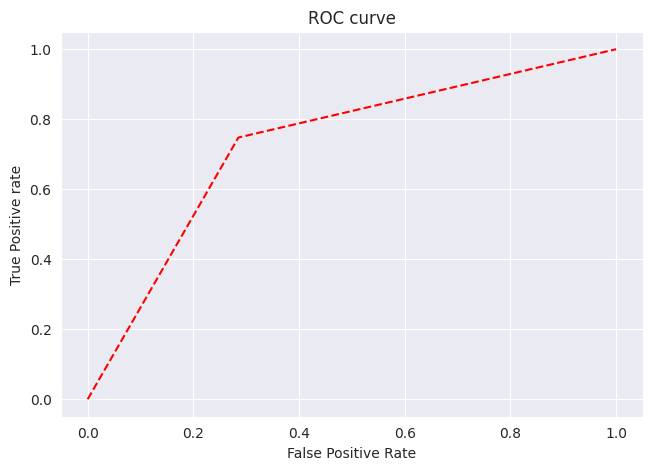

In [19]:
fpr, tpr, thresh = roc_curve(y_test, bin, pos_label=1)
sns.set_style("darkgrid")
plt.figure(figsize=(7.5,5));
plt.plot(fpr, tpr,'--r');
plt.title('ROC curve');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive rate');
plt.savefig('ROC',dpi=300);
plt.show();